In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [7]:
df

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008


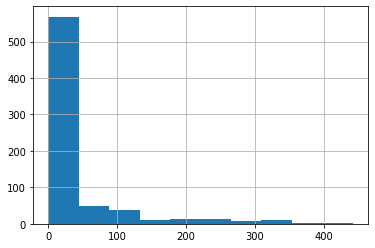

In [8]:
df['MIC'].hist()

In [9]:
df['pIC50'] = df['MIC'].apply(lambda x: -np.log(x*1e-6))

In [10]:
df

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008,23.248994


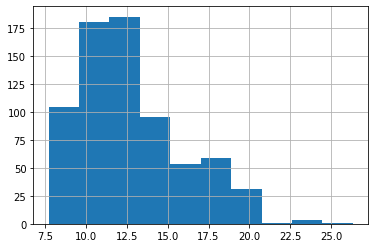

In [11]:
df['pIC50'].hist()

In [12]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [13]:
aa_freq = reduce_by_kmer_frequency(df)

In [14]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1117.09sequence/s]


In [15]:
physicochemical_prop = get_physicochemical_properties(df)

In [16]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [17]:
y = df[['pIC50', 'MIC']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [20]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [21]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [22]:
param_grid = {
    'C':[0.001,0.01,0.1,1,10,100,1000],
    'kernel':['rbf','poly','sigmoid','linear'],
    'degree':[1,2,3,4,5,6],
    'gamma': np.arange(0.1,1.0,0.1).round(1).tolist() + np.arange(1,11,1).round().tolist()
}
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=multi_objective_scorer)

In [187]:
grid_search.fit(X_train, y_train_pmic)

Fitting 5 folds for each of 3192 candidates, totalling 15960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3692 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 5448 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6454 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7668 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9046 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 10392 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 12094 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 13884 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 14897 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 15960 out of 15960 | elapsed:  5.3min finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring=make_scorer(multi_objective_score, greater_is_better=False),
             verbose=2)

In [188]:
grid_search.best_params_

{'C': 100, 'degree': 1, 'gamma': 3, 'kernel': 'rbf'}

In [189]:
best_grid = grid_search.best_estimator_

In [208]:
y_pred_pmic = best_grid.predict(X_test)

In [209]:
mean_absolute_percentage_error(y_test_pmic, y_pred_pmic)

13.40021877192078

In [210]:
np.std(y_test_pmic), np.std(y_pred_pmic)

(3.331777161170943, 2.7825742009253447)

In [211]:
np.std(y_pred_pmic) - np.std(y_test_pmic)

-0.5492029602455983

In [212]:
multi_objective_score(y_test_pmic,y_pred_pmic)

18.892248374376763

In [230]:
mean_squared_error(y_test_mic,y_pred_mic)

4081.405827081923

In [24]:
svr = SVR(C=10, gamma=10)
cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

_ = svr.fit(X_train, y_train_pmic)
y_pred = svr.predict(X_test)

print(np.std(y_test_pmic), np.std(y_pred))

[-13.14097507 -11.75919857 -14.95442238 -12.28382805 -14.98717388] -13.425119590064293
3.331777161170943 2.389467849793156


In [307]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [308]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [309]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [310]:
list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(14.0512, 13.3353, 5.095228949935188, 0.79, 1.6164, 104.61142080028122),
 (12.557, 12.5856, 0.22772176312018264, 3.52, 3.4208, 2.819016306272497),
 (10.6585, 10.6965, 0.3568205888157505, 23.5, 22.623, 3.7317633066588667),
 (11.2506, 14.3021, 27.123692294480684, 13.0, 0.6147, 95.27152573673904),
 (13.1224, 14.5293, 10.721465629449, 2.0, 0.4898, 75.51010688039112),
 (13.1124, 11.7187, 10.628726355563412, 2.02, 8.1399, 302.9661999418258),
 (10.8198, 11.4141, 5.4932856490360376, 20.0, 11.0383, 44.80850539142303),
 (10.7475, 11.6315, 8.22597115652515, 21.5, 8.8815, 58.69070968046986),
 (9.2103, 10.2241, 11.00636535500584, 100.0, 36.2865, 63.71347449287876),
 (13.1224, 14.6038, 11.289660992833756, 2.0, 0.4546, 77.26967703697946),
 (8.7403, 11.6242, 32.995385115835, 160.0, 8.9465, 94.40841707846201),
 (9.8191, 11.6292, 18.433648905994534, 54.4, 8.9025, 83.6350277494994),
 (9.2103, 9.538, 3.557413251167453, 100.0, 72.0615, 27.93847146163641),
 (18.7774, 18.2397, 2.863506243156309, 0.007, 0.01

In [311]:
ape_mic.mean()

1368837.5810242589

In [195]:
loo = LeaveOneOut()

In [196]:
from tqdm import tqdm

In [312]:
result_df = pd.DataFrame(columns = list(df.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    svr = SVR(C=100, gamma=3)
    _ = svr.fit(X_train, y_train_pmic)
    y_pred_pmic = svr.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

712it [01:23,  8.58it/s]


In [313]:
result_df#.to_csv("../results/SVM_pMIC_to_MIC_rbf_c_100_gamma_3.csv", index=False)

,Sequence,pIC50,y_pred_pmic,ape_pmic,MIC,y_pred_mic,ape_mic
0,AAQRRGRVGRNPNQVGD,7.724200675886576,8.361462550658148,8.25019832486975,442.0,233.7022822695631,47.1261804819993
0,HRILARIRQMMT,7.739015761671717,10.700061011396127,38.261263976089765,435.5,22.543562457034202,94.82352182387274
0,RNPSQVGD,7.867475568783628,10.539424188172246,33.96195636107608,383.0,26.47196821171925,93.08825895255373
0,RVGRNPNQVGD,7.891254760549742,8.069194411724098,2.254896801252929,374.0,313.0353571309643,16.300706649474783
0,AAQRRGRIGRNPSQVGD,7.934977571563574,8.522431351799682,7.4033451882883,358.0,198.95510697112056,44.42594777343002
...,...,...,...,...,...,...,...
0,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,15.977030210679716,10.553818406404428,33.943803903244714,0.11515,26.093654223293864,22560.57683308195
0,CFPYITRPGTYHDWWYTRKNRQ,15.01948336229021,10.724004622229177,28.599377464911992,0.3,22.010198975629336,7236.732991876446
0,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,18.297578546818382,18.457412218008546,0.8735236238018826,0.011309999999999999,0.00963934942139448,14.771446318351183
0,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,23.248994481254666,9.148700525918901,60.649048571561366,8e-05,106.35792234901294,132947302.93626615


In [314]:
result_df['ape_pmic'].astype('float').mean()

13.52937840632643

In [315]:
result_df['ape_mic'].astype('float').mean()

306137.2650944941

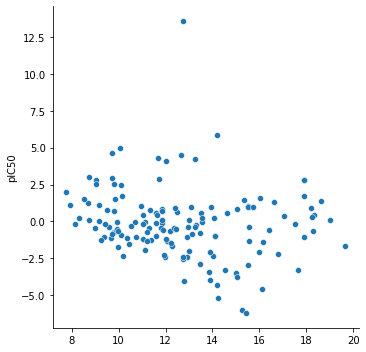

In [213]:
sns.relplot(x=y_pred_pmic, y=(y_test_pmic-y_pred_pmic))

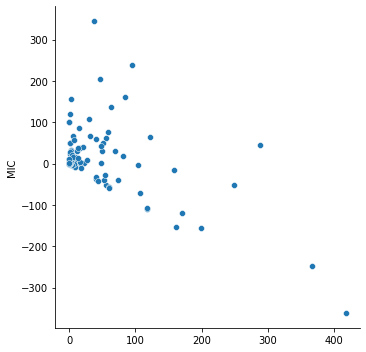

In [216]:
sns.relplot(x=y_pred_mic, y=(y_test_mic-y_pred_mic))

In [142]:
import matplotlib.pyplot as plt

(array([105.,  12.,  11.,   6.,   2.,   2.,   2.,   0.,   2.,   1.]),
 array([3.70000000e-06, 3.83000033e+01, 7.66000030e+01, 1.14900003e+02,
        1.53200002e+02, 1.91500002e+02, 2.29800001e+02, 2.68100001e+02,
        3.06400001e+02, 3.44700000e+02, 3.83000000e+02]),
 <a list of 10 Patch objects>)

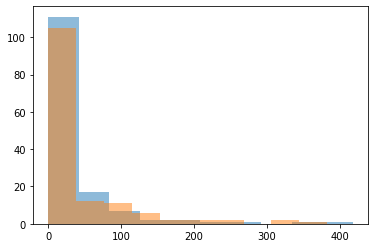

In [217]:
plt.hist(y_pred_mic, alpha=0.5)
plt.hist(y_test_mic, alpha=0.5)

In [316]:
params2 = ['molecular_weight', 'aromaticity', 'instability_index',
          'isoelectric_point', 'helix', 'turn', 'sheet', 'with_reduced_cysteines',
          'with_disulfid_bridges', 'gravy', 'net_charge_at_pH7point4']

In [317]:
prop2 = []
for seq in df.Sequence:
    X = ProteinAnalysis(seq)
    molecular_weight = X.molecular_weight()
    aromaticity = X.aromaticity()
    instability_index = X.instability_index()
    isoelectric_point = X.isoelectric_point()
    sec_struc = X.secondary_structure_fraction()
    helix = sec_struc[0]
    turn = sec_struc[1]
    sheet = sec_struc[2]
    epsilon_prot = X.molar_extinction_coefficient()
    with_reduced_cysteines = epsilon_prot[0]
    with_disulfid_bridges = epsilon_prot[1]
    gravy = X.gravy() # hydrophobicity related
    # flexibility = X.flexibility()
    # X.protein_scale()
    net_charge_at_pH7point4 = X.charge_at_pH(7.4)

    prop2.append([seq, molecular_weight, aromaticity, instability_index, isoelectric_point, helix, turn, sheet,
                 with_reduced_cysteines, with_disulfid_bridges, gravy, net_charge_at_pH7point4])
prop2 = pd.DataFrame(prop2, columns=["Sequence"]+params2)

In [318]:
merged_res = prop2.merge(result_df,on=['Sequence'],how='left')#.to_csv("../results/SVM_pMIC_to_MIC_rbf_c_100_gamma_3.csv", index=False)

In [319]:
pd.concat([merged_res, freq], axis=1)[['Sequence', 'AA_Frequence', 'molecular_weight', 'aromaticity', 'instability_index',
       'isoelectric_point', 'helix', 'turn', 'sheet', 'with_reduced_cysteines',
       'with_disulfid_bridges', 'gravy', 'net_charge_at_pH7point4', 'pIC50',
       'y_pred_pmic', 'ape_pmic', 'MIC', 'y_pred_mic', 'ape_mic']].to_csv("../results/SVM_pMIC_to_MIC_rbf_c_100_gamma_3.csv", index=False)

### Test with external sequence from https://www.biorxiv.org/content/10.1101/2021.04.07.438720v1.full.pdf

In [25]:
test = pd.DataFrame([['AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS', 2.09995035],
                     ['AAGMGFFGAR', 1.108873537],
                     ['AEVAPAPAAAAPAKAPKKKAAAKPKKAGPS', 0.301029996],
                     ['AGLQFPVGRIGRLLRK', 0.799340549]], columns=["Sequence", "logMIC"])

In [26]:
"A G L Q F P V G R I G R L L R K".replace(" ", "")

'AGLQFPVGRIGRLLRK'

In [27]:
test

,Sequence,logMIC
0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,2.099950
1,AAGMGFFGAR,1.108874
2,AEVAPAPAAAAPAKAPKKKAAAKPKKAGPS,0.301030
3,AGLQFPVGRIGRLLRK,0.799341


In [35]:
test_aa = reduce_by_kmer_frequency(test, kmer=1)

In [36]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

test_protvec = convert_sequences_to_avg_vectors(test['Sequence'], uniprot_embedding, kmer=3)
test_protvec = test_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 4/4 [00:00<00:00, 863.38sequence/s]


In [37]:
test_physicochemical_prop = get_physicochemical_properties(test)

In [39]:
test_X = pd.concat([test_aa, test_protvec, test_physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [40]:
test_X

,A,C,D,E,F,G,H,I,K,L,...,93,94,95,96,97,98,99,helix,turn,sheet
0,0.363636,0.0,0.0,0.030303,0.090909,0.121212,0.030303,0.060606,0.121212,0.030303,...,-0.050261,-0.035223,-0.007174,-0.017427,0.026892,0.042279,-0.029710,0.212121,0.212121,0.454545
1,0.300000,0.0,0.0,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.000000,...,0.016016,-0.092961,-0.038149,-0.127626,0.062860,0.090750,0.022793,0.200000,0.300000,0.400000
2,0.433333,0.0,0.0,0.033333,0.000000,0.033333,0.000000,0.000000,0.233333,0.000000,...,-0.046730,-0.018758,0.023030,-0.042691,0.049952,0.022467,-0.073138,0.033333,0.266667,0.466667
3,0.062500,0.0,0.0,0.000000,0.062500,0.187500,0.000000,0.062500,0.062500,0.187500,...,0.015827,-0.035545,-0.013302,-0.045987,-0.015051,0.049690,0.027801,0.375000,0.250000,0.250000


In [41]:
y_pred = svr.predict(test_X)

In [42]:
y_pred

array([10.99643867, 12.2772363 , 11.59824915, 12.06680136])

In [43]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [44]:
y_pred_mic

array([16.76128712,  4.65654733,  9.18215024,  5.74717944])

In [45]:
np.log(y_pred_mic)

array([2.81907189, 1.53827426, 2.21726141, 1.7487092 ])

In [46]:
test['logMIC'].values

array([2.09995035, 1.10887354, 0.30103   , 0.79934055])